# Here we will look at the evolution of term usage over time in the corpus

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import bigrams, trigrams

from collections import Counter
import re
import pickle

In [112]:
# read in the dataframe grabbing only PY, DE, ID columns
with open("peds_spine_v1_from_R.pkl", "rb") as f:
    df = pickle.load(f)[['TI',"PY", "DE", "ID",'AB']]

# DE is authors keywords
# ID is WoS keywords
# TI is title
# rename columns
df.columns = ["title", "year", "authors_keywords", "wos_keywords",'abstract']

# Fill NaN values with empty strings for concatenation
df['authors_keywords'].fillna('', inplace=True)
df['wos_keywords'].fillna('', inplace=True)

# Concatenate the keyword columns
df['all_words'] = df['title'] + '; ' + df['authors_keywords'] + '; ' + df['wos_keywords']

# create a column for the corresponding decade
df['decade'] = (df['year'] // 10) * 10

# inspect the data for a sample of 10 papers
df.sample(10)

,title,year,authors_keywords,wos_keywords,abstract,all_words,decade
380,INTELLECTUAL OUTCOME IN CHILDREN WITH MALIGNAN...,1995,MALIGNANT TUMORS OF THE POSTERIOR FOSSA; INTEL...,LONG-TERM SURVIVORS; COGNITIVE DEFICITS; BRAIN...,THE PURPOSE OF THIS STUDY WAS TO DETERMINE THE...,INTELLECTUAL OUTCOME IN CHILDREN WITH MALIGNAN...,1990
6254,IMPACT OF PELVIC OBLIQUITY ON CORONAL ALIGNMEN...,2020,ADOLESCENT IDIOPATHIC SCOLIOSIS; PELVIC OBLIQU...,SHOULDER BALANCE; AXIAL ROTATION; CURVE; ASYMM...,STUDY DESIGNRETROSPECTIVE STUDY.OBJECTIVETO IN...,IMPACT OF PELVIC OBLIQUITY ON CORONAL ALIGNMEN...,2020
448,"EEG, PET, SPET AND MRI IN INTRACTABLE CHILDHOO...",1995,SPET; PET; EEG; MRI; DRUG-RESISTANT EPILEPSY; ...,TEMPORAL-LOBE EPILEPSY; POSITRON EMISSION TOMO...,"MAGNETIC RESONANCE IMAGING (MRI), SINGLE PHOTO...","EEG, PET, SPET AND MRI IN INTRACTABLE CHILDHOO...",1990
10613,THE EFFECTS OF CARBON DIOXIDE ON MEASURING CER...,2009,IDIOPATHIC INTRACRANIAL HYPERTENSION; BENIGN I...,IDIOPATHIC INTRACRANIAL HYPERTENSION,THE EFFECTS OF PCO2 ON CEREBRAL SPINAL FLUID (...,THE EFFECTS OF CARBON DIOXIDE ON MEASURING CER...,2000
7495,ACCURACY OF COMPUTER-ASSISTED PEDICLE SCREW PL...,2023,ADOLESCENT IDIOPATHIC SCOLIOSIS; PEDICLE SCREW...,MULTILEVEL REGISTRATION; REFERENCE FRAME; SURG...,PURPOSE TO COMPARE THE ACCURACY OF PEDICLE SCR...,ACCURACY OF COMPUTER-ASSISTED PEDICLE SCREW PL...,2020
299,DELAYED POSTOPERATIVE TETHERING OF THE CERVICA...,1994,TETHERED SPINAL CORD; CHIARI MALFORMATION; CAV...,,TETHERING OF THE SPINAL CORD IN THE LUMBAR AND...,DELAYED POSTOPERATIVE TETHERING OF THE CERVICA...,1990
1371,SEVERE SPINAL CORD INJURY IN CRANIOCERVICAL DI...,2013,ATLANTO-AXIAL LUXATION; ATLANTO-OCCIPITAL DIST...,CERVICAL-SPINE; TRAUMA,"CRANIOCERVICAL DISTRACTION INJURIES, INCLUDING...",SEVERE SPINAL CORD INJURY IN CRANIOCERVICAL DI...,2010
4021,RISK FACTORS OF NON-SPECIFIC SPINAL PAIN IN CH...,2018,BACK PAIN; RISK FACTOR; RISK ASSESSMENT; QUEST...,LOW-BACK-PAIN; DANISH SCHOOL-CHILDREN; NECK PA...,NON-SPECIFIC SPINAL PAIN CAN OCCUR AT ALL AGES...,RISK FACTORS OF NON-SPECIFIC SPINAL PAIN IN CH...,2010
10686,VAGUS NERVE STIMULATION IN CHILDREN WITH INTRA...,2009,VAGUS NERVE STIMULATION; EPILEPSY; CHILDREN; V...,REFRACTORY EPILEPSY,"PURPOSE TO ANALYZE THE INDICATION, COMPLICATIO...",VAGUS NERVE STIMULATION IN CHILDREN WITH INTRA...,2000
3213,EPIDEMIOLOGIC AND DEMOGRAPHIC ATTRIBUTES OF PR...,2016,DISC SPACE INFECTION; INFECTIVE SPONDYLITIS; P...,VERTEBRAL OSTEOMYELITIS; INFECTIOUS SPONDYLODI...,BACKGROUND: THE PREVALENCE AND CHARACTERISTICS...,EPIDEMIOLOGIC AND DEMOGRAPHIC ATTRIBUTES OF PR...,2010


## generating wordclouds for Figure 5

In [26]:
# using nltk for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidkurland/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/davidkurland/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [37]:
# define a function to create a wordcloud
# we can use lemmatization or not

def create_wordcloud(year_range, n=50, keywords_df=df, lemmatize=False):
    
    def preprocess_keywords(keywords):
        if lemmatize:
            return [lemmatizer.lemmatize(word) for word in keywords]
        return keywords

    data_range = keywords_df[
        (keywords_df["year"] >= year_range[0]) & (keywords_df["year"] <= year_range[1])
    ]
    all_keywords = pd.concat(
        [data_range["wos_keywords"].str.split(";"), data_range["authors_keywords"].str.split(";")]
    ).dropna()

    # Flatten and preprocess
    flat_keywords = [item.strip() for sublist in all_keywords for item in sublist]
    flat_keywords = preprocess_keywords(flat_keywords)
    keyword_count = Counter(flat_keywords)

    # Get the n most common keywords
    top_keywords = keyword_count.most_common(n)
    top_keywords_dict = dict(top_keywords)

    # Generate the word cloud
    wordcloud = WordCloud(
        background_color="white", width=800, height=400
    ).generate_from_frequencies(top_keywords_dict)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    plt.show()

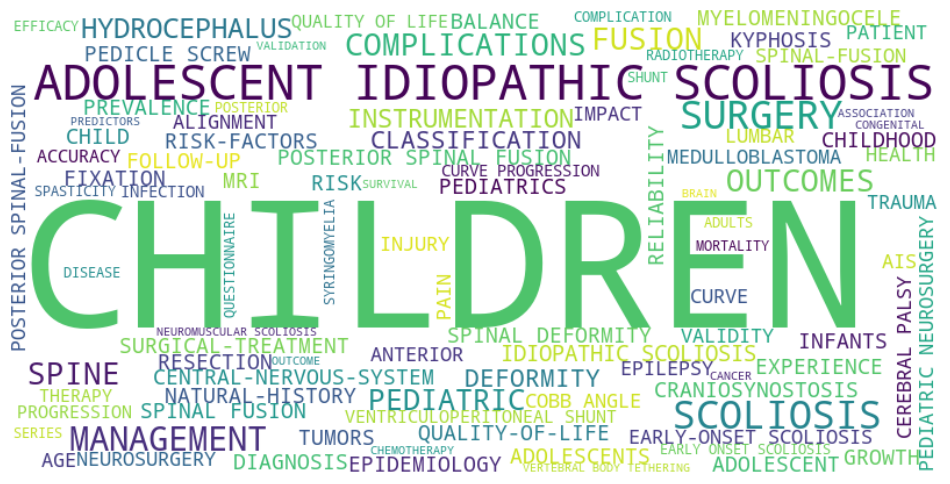

In [33]:
create_wordcloud([2020, 2023], 100, df, lemmatize=True)


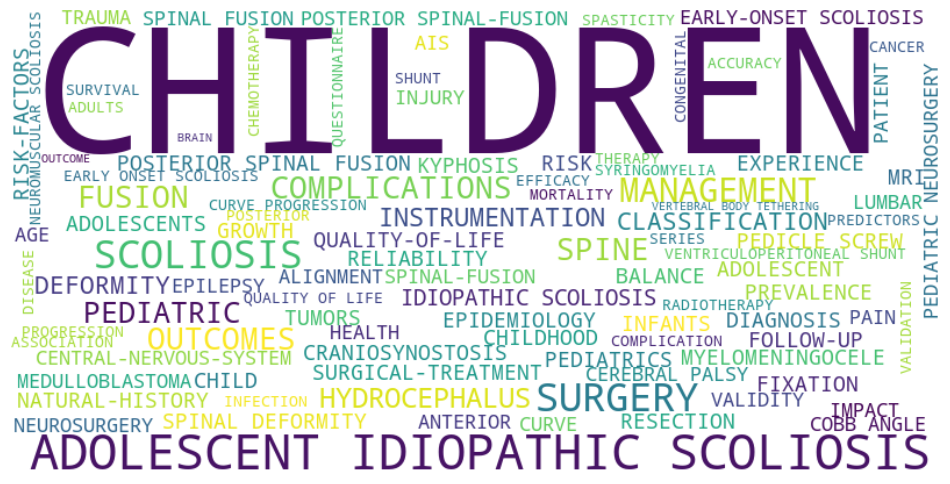

In [34]:
create_wordcloud([2020, 2023], 100, df, lemmatize=False)

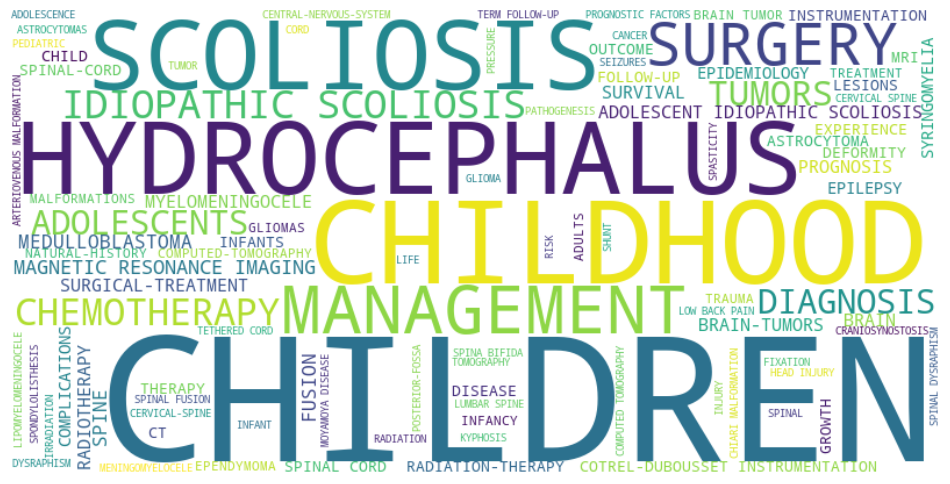

In [35]:
create_wordcloud([1980, 2000], 100, df, lemmatize=True)

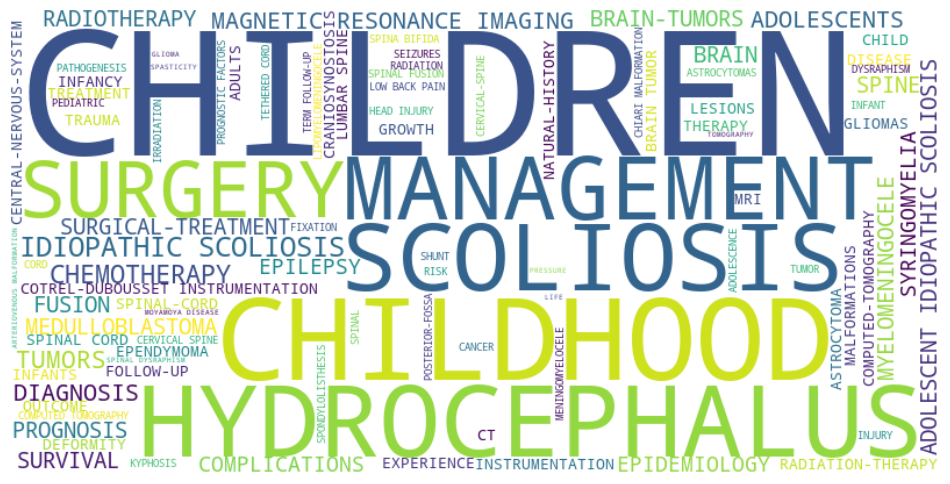

In [36]:
create_wordcloud([1980, 2000], 100, df, lemmatize=False)

## Now we'll look at how terms have appeared in titles/abstracts over time

## Generating the rest of figure 5

In [186]:
# prepare the data for the term analysis
# Create a copy of your slice
titles = df[['title','abstract', 'year']].copy()

# define a function to process the title terms into unigrams, bigrams, and trigrams

def process_titles(titles_df):
    # Copy the input dataframe
    df = titles_df.copy()

    df["title"] = df["title"].fillna("")
    df["abstract"] = df["abstract"].fillna("")

    # Remove punctuation
    df["title"] = df["title"].str.replace(r"[^\w\s]", "")
    df["abstract"] = df["abstract"].str.replace(r"[^\w\s]", "")

    # Remove numbers
    df["title"] = df["title"].str.replace(r"\d+", "")
    df["abstract"] = df["abstract"].str.replace(r"\d+", "")

    # Remove extra whitespace
    df["title"] = df["title"].str.replace(r"\s+", " ")
    df["abstract"] = df["abstract"].str.replace(r"\s+", " ")

    # tokenize the titles
    df["tokens"] = df["title"].str.split(" ")

    # Tokenize the titles and abstracts if you wish to look at them together
    # df["tokens"] = df["title"].str.split(" ") + df["abstract"].str.split(" ")

    # Generate bigrams and trigrams
    df["bigrams"] = df["tokens"].apply(lambda x: [" ".join(bg) for bg in bigrams(x)])
    df["trigrams"] = df["tokens"].apply(lambda x: [" ".join(tg) for tg in trigrams(x)])

    # Concatenate unigrams, bigrams, and trigrams
    df["terms"] = df["tokens"] + df["bigrams"] + df["trigrams"]
    
    df["articles_per_year"] = df.groupby("year")["year"].transform("count")

    # Explode the 'terms' column into multiple rows
    df = df.explode("terms")

    # Create a new dataframe with the necessary aggregations
    df2 = df.groupby(["year", "terms"]).size().reset_index(name="year_term_count")

    # Get total term count across all years
    total_term_count = df.groupby("terms").size()
    df2["total_term_count"] = df2["terms"].map(total_term_count)

    # Get number of years a term appears
    n_years = df.groupby("terms")["year"].nunique()
    df2["n_years"] = df2["terms"].map(n_years)

    # Get articles_per_year from the original dataframe
    articles_per_year = df.groupby("year")[
        "articles_per_year"
    ].first()  # assuming articles_per_year is same for all terms in a year
    df2["articles_per_year"] = df2["year"].map(articles_per_year)

    df2.reset_index(drop=True, inplace=True)
    df2["terms"] = df2["terms"].str.lower()
    
    return df2

# Use the function
titles_processed = process_titles(titles)

# inspect a sample of the processed dataframe
titles_processed.sample(10)


/var/folders/rd/l5ly5dfd6xl05wxl122lvxn00000gn/T/ipykernel_78264/2061048372.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df["title"] = df["title"].str.replace(r"[^\w\s]", "")
/var/folders/rd/l5ly5dfd6xl05wxl122lvxn00000gn/T/ipykernel_78264/2061048372.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df["abstract"] = df["abstract"].str.replace(r"[^\w\s]", "")
/var/folders/rd/l5ly5dfd6xl05wxl122lvxn00000gn/T/ipykernel_78264/2061048372.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df["title"] = df["title"].str.replace(r"\d+", "")
/var/folders/rd/l5ly5dfd6xl05wxl122lvxn00000gn/T/ipykernel_78264/2061048372.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df["abstract"] = df["abstract"].str.replace(r"\d+", "")
/var/folders/rd/l5ly5dfd6xl05wxl122lvxn00000gn/T/ipykernel_78264

,year,terms,year_term_count,total_term_count,n_years,articles_per_year
64115,2006,adolescence a to,1,1,1,386
91443,2009,dural attachment,1,3,3,391
143515,2014,improved clinical outcomes,1,1,1,481
160773,2015,treatment of early,1,5,5,478
268909,2023,touched vertebra while,1,1,1,404
126218,2012,teratoidrhabdoid tumor,2,20,13,444
75618,2007,in epidemiology,1,2,2,411
124438,2012,postulating the,1,1,1,444
152956,2015,craniosynostosis,1,87,29,478
95032,2009,postoperative swallowing,1,2,2,391


In [221]:
# calculate the # of unique n-grams
n_grams = len(titles_processed['terms'].unique())
print(f'There are {n_grams} unique n-grams in the dataset.')

There are 153331 unique n-grams in the dataset.


In [204]:
def count_terms(df, regex_dict):
    """
    Counts occurrences of terms matching provided regular expressions in the dataframe
    and returns yearly counts, normalized frequencies, and cumulative percentages.
    """
    output_df = pd.DataFrame({"year": range(1900, 2024)})
    
    # Count occurrences and calculate metrics for each regex
    def process_regex(term, regex):
        regex_df = (
            df[df["terms"].str.contains(regex, flags=re.IGNORECASE)]
            .groupby("year")
            .agg(year_term_count=('year_term_count', 'sum'),
                 articles_per_year=('articles_per_year', 'first'))
            .reset_index()
            .merge(output_df, on="year", how="right")
            .fillna(0)
            .sort_values(by='year')
        )
        
        regex_df["term"] = term
        regex_df["normalized_frequency"] = regex_df["year_term_count"] / regex_df["articles_per_year"]
        regex_df["cumulative_normalized_frequency"] = regex_df.groupby("term")["normalized_frequency"].cumsum()
        regex_df["cumulative_percentage"] = (
            regex_df["cumulative_normalized_frequency"]
            / regex_df.groupby("term")["normalized_frequency"].transform("sum")
        ) * 100
        
        # Find the first year the term appears and add a row with 0% for the year before that
        # this makes the plot start at 0% for the first year the term appears, visually more appealing
        first_year = regex_df[regex_df["cumulative_percentage"] > 0]["year"].min()
        if first_year:
            mask = (regex_df["term"] == term) & (regex_df["year"] == first_year - 1)
            regex_df.loc[mask, "cumulative_percentage"] = 0

        return regex_df

    return pd.concat([process_regex(term, regex) for term, regex in regex_dict.items()], ignore_index=True)


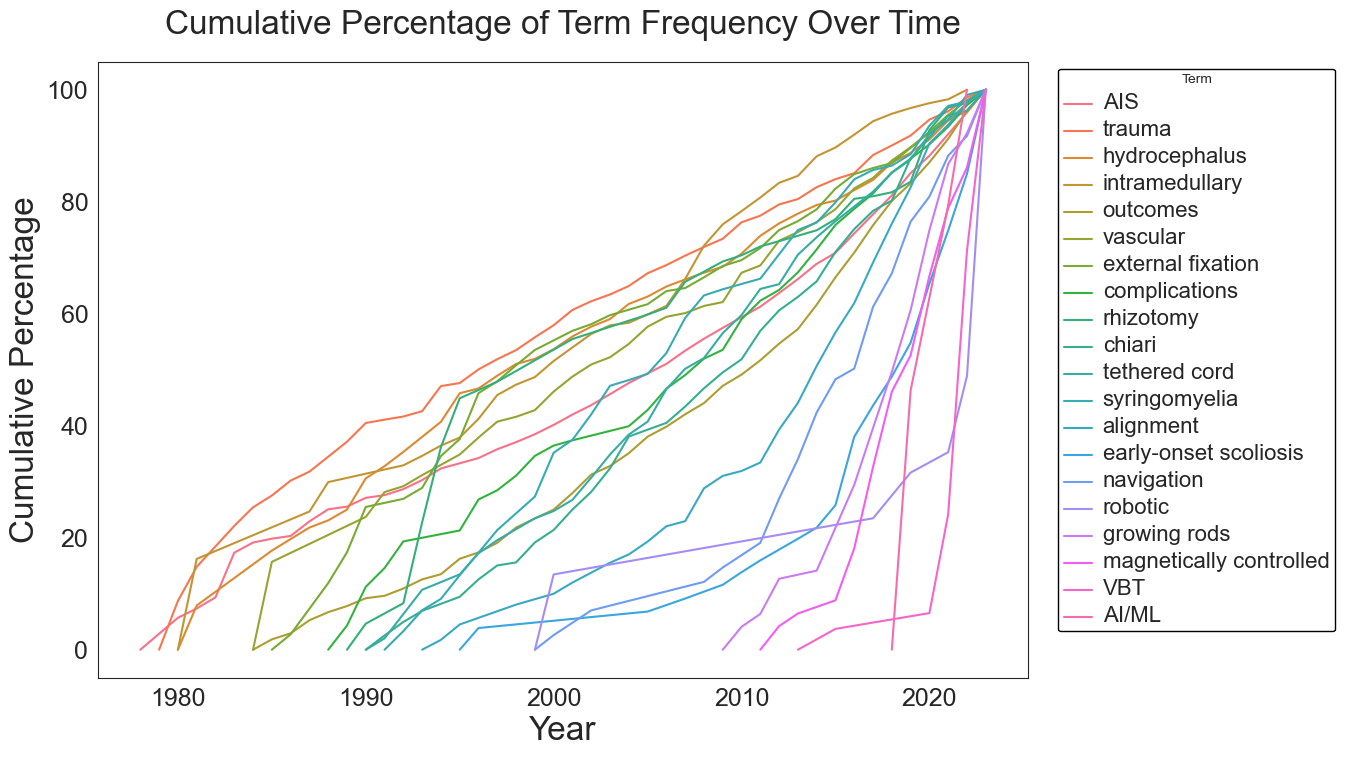

In [219]:
regex_dict = {'early-onset scoliosis': r"\b\w*(?:early-onset|early onset)\w*\b",
              'AIS': r"\b\w*(?:adolescent idiopathic)\w*\b",
              'outcomes': r"\b\w*(?:outcome)\w*\b",
              'chiari': r"\b\w*(?:chiari)\w*\b",
              'trauma': r"\b\w*(?:trauma)\w*\b",
              'VBT': r"\b\w*(?:vertebral body tethering|VBT)\w*\b",
              'navigation': r"\b\w*(?:navigat)\w*\b",
              'robotic': r"\b\w*(?:robot)\w*\b",
              'complications': r"\b\w*(?:complication)\w*\b",
            #   'fusion': r"\b\w*(?:fusion|arthrodesis)\w*\b",
              'alignment': r"\b\w*(?:alignment|sagittal balance)\w*\b",
              'AI/ML': r"\b\w*(?:artificial intelligence|machine learning)\w*\b",
              'hydrocephalus': r"\b\w*(?:hydrocephalus)\w*\b",
            #   'tumor':r"\b\w*(?:tumor|onco|metas)\w*\b",
              'external fixation':r"\b\w*(?:external fixation|halo)\w*\b",
              'growing rods':r"\b\w*(?:growing rods)\w*\b",
              'magnetically controlled':r"\b\w*(?:magnetically controlled)\w*\b",
              'intramedullary':r"\b\w*(?:intramedullary)\w*\b",
              'tethered cord':r"\b\w*(?:tethered cord)\w*\b",
            #   'cervical spine':r"\b\w*(?:cervical spine)\w*\b",
              'rhizotomy':r"\b\w*(?:rhizotomy)\w*\b",
              'vascular':r"\b\w*(?:vascular)\w*\b",
            #   'surgery':r"\b\w*(?:surgery|surgical)\w*\b",
              'syringomyelia':r"\b\w*(?:syringomyelia)\w*\b",
              # 'myelomeningocele':r"\b\w*(?:meningo|myelo)\w*\b",
              # 'tuberculosis':r"\b\w*(?:tubercul)\w*\b",
              # 'scoliosis':r"\b\w*(?:scoli|curv|deform)\w*\b",
             }

result = count_terms(titles_processed, regex_dict)

# define a function to obtain the order of the terms for plotting (helper function for the legend)
def get_hue_order(df):

    unique_terms = list(df["term"].unique())
    term_min_year = {}

    for term in unique_terms:
        min_year = df.query("term == @term and cumulative_percentage > 0")["year"].min()
        term_min_year[term] = min_year

    sorted_terms = sorted(term_min_year.items(), key=lambda x: x[1])

    hue_order = []

    for sorted_term in sorted_terms:
        ordered_term = sorted_term[0]
        hue_order.append(ordered_term)

    return hue_order

plt.figure(figsize=(12, 8))
sns.set_style("white")
sns.set_palette("colorblind")
hue_order = get_hue_order(result)

# Plot the line graph using Seaborn
ax = sns.lineplot(
    x="year", y="cumulative_percentage", hue="term", hue_order=hue_order, data=result
)
plt.xlabel("Year", size=24)
plt.ylabel("Cumulative Percentage", size=24)
plt.title("Cumulative Percentage of Term Frequency Over Time", size=24, pad=20)

# Set the tick label parameters
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

# Set the legend parameters
leg = ax.legend(
    title="Term",
    facecolor="white",
    edgecolor="black",
    framealpha=1,
    bbox_to_anchor=(1.025, 1),
    loc="upper left",
)
plt.setp(
    leg.get_texts(), fontsize=16
)  # You can adjust the legend text size if necessary

plt.show()